# Finding connected components in a graph:
This project was realized by: Nizar Masmoudi, Ahmed Belgacem, Fatma Zahra Zakhama.  


# Introduction:
In this project we tackle the problem of finding connected components in a graph.  
Throughout this work finding connected components is defined as  disjoint subgraphs in which any two vertices are connected to each other by paths.  

We use the article [CCF: Fast and Scalable Connected Component
Computation in MapReduce](https://www.cse.unr.edu/~hkardes/pdfs/ccf.pdf) by Hakan Kardes, Siddharth Agrawal, Xin Wang, and Ang Sun as a reference. The article presents a MapReduce scalable approch.

The method proposed in this article for finding connected components in a given graph is shown in the figure below.


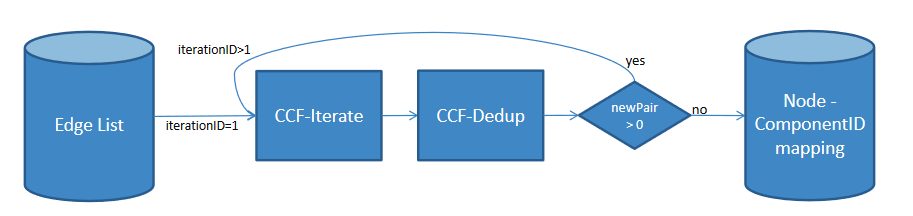

The input of the Connected Component Finder (CCF) module is the edge list. As an output from the module, we want the mapping from each node in the
graph to its corresponding componentID. For simplicity, we
use the smallest node id in each connected component as the
identifier of that component.

Throughout this notebook we provide a spark implementation to the MapReduce algorithm.
First we will try with the small graph introduced in the article to check our implementation is working well. We will use networkx for the graph implementation. Then we will use the [Web-Google dataset](http://snap.stanford.edu/data/web-Google.html).  

## Installing and importing modules:

In [3]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 7.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=eccbb0c39fdb7084252f9bb9def6e756e4f3120f32fa62cfcd669182db84071c
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


In [4]:
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.rdd import RDD, PipelinedRDD
from typing import Any, Iterator, Generator
from pyspark.accumulators import Accumulator
import networkx as nx
import matplotlib.pyplot as plt
sc = SparkContext.getOrCreate(SparkConf().setMaster('local[*]'))

# Preparing the graph

First we will be trying our implementation on the graph presented as an example in the article. The implementation should only need 4 iterations

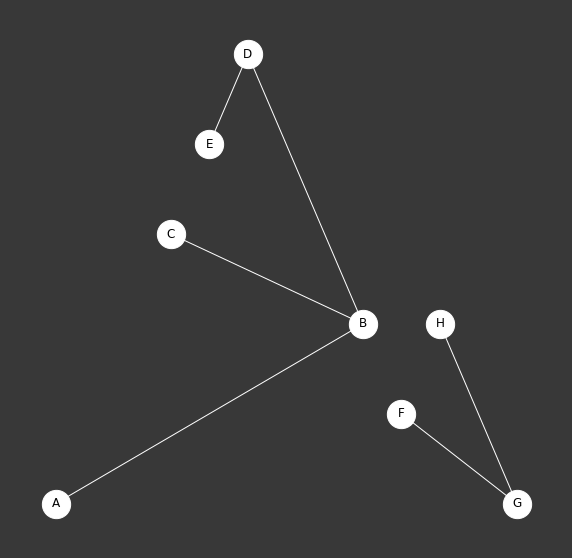

In [6]:
plt.rcParams['figure.facecolor'] = '383838'
plt.rcParams['axes.facecolor'] = '383838'
plt.rcParams['axes.spines.right'] = plt.rcParams['axes.spines.left'] = plt.rcParams['axes.spines.top'] = plt.rcParams['axes.spines.bottom'] = False

nodes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
edges = [('A', 'B'), ('B', 'C'), ('B', 'D'), ('D', 'E'), ('F', 'G'), ('G', 'H')]
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.planar_layout(G)

plt.figure(figsize = (10, 10))
nx.draw_networkx(G, pos, node_size = 800, edge_color = 'w', node_color = 'w')

In [7]:
nodes = list(G.nodes)
edge_list = [(nodes.index(x), nodes.index(y)) for x, y in G.edges]

# Connected Component Finder(CCF) Module

In [21]:
class CCF:
  class Iterate:
    @staticmethod
    def map(x: Iterator) -> tuple:
      key, value = x
      return ((key, value), (value, key))
    
    @staticmethod
    def reduce(x: Iterator, counter: Accumulator = None) -> Generator:
      key, values = x
      value_list = []
      min_ = key
      for value in values:
        if value < min_:
          min_ = value
        value_list.append(value)
      if (min_ < key):
        yield (key, min_)
        for value in value_list:
          if min_ != value:
            if counter: counter.add(1)
            yield (value, min_)
  class IterateSS(Iterate):
    @staticmethod
    def reduce(x: Iterator, counter: Accumulator = None) -> Generator:
      key, values = x
      min_ = values[0]
      if(min_ < key):
        yield(key, min_)
        for value in values[1:]:
          yield(value, min_)
          if counter: counter.add(1)

  class Dedup:
    @staticmethod
    def map(x: Iterator) -> tuple:
      key, value = x
      return ((key, value), None)
    @staticmethod
    def reduce(x: Iterator) -> tuple:
      key, value = x
      return (key[0], key[1])

class CCFSpark:
  def __init__(self, sc: SparkContext, rdd):
    self.sc = sc
    self.counter = sc.accumulator(0)
    self.rdd = rdd
  def iterate(self):
    counter = self.counter # To avoid SPARK-5063 error.
    counter.value = 1
    n_iter = 1
    while counter.value > 0:
      counter.value = 0
      self.rdd = self.rdd.flatMap(CCF.Iterate.map)
      self.rdd = self.rdd.groupByKey().flatMap(lambda x: CCF.Iterate.reduce(x, counter))
      self.rdd = self.rdd.map(CCF.Dedup.map)
      self.rdd = self.rdd.groupByKey().map(CCF.Dedup.reduce)
      self.rdd.collect()
      print('Iteration {} - Counter = {}'.format(n_iter, counter.value))
      n_iter += 1
      if counter.value == 0:
        break
  def iterateSS(self):
    counter = self.counter # To avoid SPARK-5063 error.
    counter.value = 1
    n_iter = 1
    while counter.value > 0:
      counter.value = 0
      self.rdd = self.rdd.flatMap(CCF.Iterate.map)
      self.rdd = self.rdd.groupByKey().map(lambda x: (x[0], sorted(x[1]))).flatMap(lambda x: CCF.Iterate.reduce(x, counter))
      self.rdd = self.rdd.map(CCF.Dedup.map)
      self.rdd = self.rdd.groupByKey().map(CCF.Dedup.reduce)
      self.rdd.collect()
      print('Iteration {} - Counter = {}'.format(n_iter, counter.value))
      n_iter += 1
      if counter.value == 0:
        break

Let's try the implementation on the graph first with the naive iterate then with secondary sorting.

In [24]:
rdd = sc.parallelize(edge_list)
finder = CCFSpark(sc, rdd)
finder.iterate()

Iteration 1 - Counter = 4
Iteration 2 - Counter = 9
Iteration 3 - Counter = 4
Iteration 4 - Counter = 0


In [25]:
rdd = sc.parallelize(edge_list)
finder = CCFSpark(sc, rdd)
finder.iterateSS()

Iteration 1 - Counter = 4
Iteration 2 - Counter = 9
Iteration 3 - Counter = 4
Iteration 4 - Counter = 0


We can see that our implementation only needed 4 iterations as the result seen in the article.

# Trying the implementation on the Web Google Dataset

We will be trying now the implementation on the [Web Google Dataset](https://snap.stanford.edu/data/web-Google.html?fbclid=IwAR1R7_UjSSgmG9Mcr32ociPSGetOA9TrHCY1Wdx7VyjuT1JY6KskIp_BJcU). 

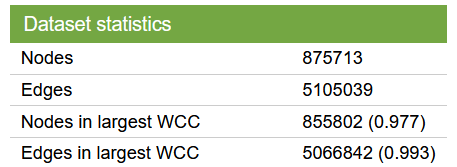

The website shows that the largest connected component in the graph consists of 855802 nodes. As our approch uses the smallest node in each component as ComponentID, we should find 855801 nodes in the largest connected component after running the algorithm.

In [10]:
!wget http://snap.stanford.edu/data/web-Google.txt.gz
!gzip -d /content/web-Google.txt.gz

--2023-02-16 14:30:10--  http://snap.stanford.edu/data/web-Google.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21168784 (20M) [application/x-gzip]
Saving to: ‘web-Google.txt.gz’

web-Google.txt.gz   100%[===================>]  20.19M  5.89MB/s    in 3.4s    

2023-02-16 14:30:14 (5.89 MB/s) - ‘web-Google.txt.gz’ saved [21168784/21168784]



In [11]:
!head /content/web-Google.txt

# Directed graph (each unordered pair of nodes is saved once): web-Google.txt 
# Webgraph from the Google programming contest, 2002
# Nodes: 875713 Edges: 5105039
# FromNodeId	ToNodeId
0	11342
0	824020
0	867923
0	891835
11342	0
11342	27469


In [12]:
!tail -n +5 /content/web-Google.txt > graph.txt

In [13]:
!head /content/graph.txt

0	11342
0	824020
0	867923
0	891835
11342	0
11342	27469
11342	38716
11342	309564
11342	322178
11342	387543


In [14]:
graph = sc.textFile('/content/graph.txt').map(lambda x : x.split('\t')).map(lambda x: (int(x[0]), int(x[1])))

In [15]:
finder = CCFSpark(sc, graph)
finder.iterate()

Iteration 1 - Counter = 8552232
Iteration 2 - Counter = 4758451
Iteration 3 - Counter = 3278772
Iteration 4 - Counter = 3888454
Iteration 5 - Counter = 1905323
Iteration 6 - Counter = 86783
Iteration 7 - Counter = 1318
Iteration 8 - Counter = 0


In [16]:
finder.rdd.map(lambda x: (x[1], 1))\
          .reduceByKey(lambda x, y: x + y)\
          .sortBy(lambda x: x[1], ascending = False)\
          .take(10)

[(0, 855801),
 (1734, 403),
 (1363, 383),
 (2919, 318),
 (5400, 252),
 (8107, 173),
 (4390, 114),
 (12615, 99),
 (6532, 91),
 (16674, 80)]

We can see we have the right number of nodes in the largest connected component.